In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from tqdm import tqdm
from rl_glue import RLGlue

from tbu_gym.tbu_discrete import TruckBackerEnv_D

import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque


In [10]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-5, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, buffer_size=50000, batch_size=64):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        # device, not needed, but needed if going on canada compute to specify gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.q_nn = self.build_nn().to(self.device) # build q network
        self.target_net = self.build_nn().to(self.device) # build target network
        self.target_net.load_state_dict(self.q_nn.state_dict()) # make target net same as q net. initialization is random so need this
        self.optimizer = optim.Adam(self.q_nn.parameters(), lr=lr) 
        
    def build_nn(self): # to build the q network, 2 hiddne layer with relu and 128 neuronsin each
        return nn.Sequential(
            nn.Linear(self.state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_dim)
        )
    
    def agent_policy(self, state): # act e greedy
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim) # rand action
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device) # convert state to tensor, then add batch dimension, then move to device
        with torch.no_grad(): # dont calculate gradients, no need
            q_values = self.q_nn(state)
        return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # store transition sars, done is if terminal state
    
    def train_with_mem(self): # train with experience from memory using batch size set in agent
        if len(self.memory) < self.batch_size: # if not enought mem, could be changed to use what we have instead of skip
            return
        batch = random.sample(self.memory, self.batch_size) # get batch
        states, actions, rewards, next_states, dones = zip(*batch) # get batch features

        # convert data to tensors which can be used by pytorch
        states = torch.tensor(np.stack(states), dtype=torch.float32).to(self.device) 
        next_states = torch.tensor(np.stack(next_states), dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # get current q values from q network
        q_values = self.q_nn(states).gather(1, actions)

        # use the samples from experience batch to calc target network q values
        with torch.no_grad(): # no need to calc gradients for target
            next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]  
        # target = r + gamma * max_a' Q(s', a') * (1 - done)
        target = rewards + self.gamma * next_q_values * (1 - dones)

        # mean squared error 
        errors = target - q_values
        squared_errors = errors ** 2
        mean_squared_error = torch.mean(squared_errors)

        self.optimizer.zero_grad()
        mean_squared_error.backward()
        self.optimizer.step()
 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

    
    def update_target(self): # update target network replacing it with the current q network
        self.target_net.load_state_dict(self.q_nn.state_dict())

In [11]:
import numpy as np
import matplotlib.pyplot as plt

#hyper params, these are set by default in the agent but can be changed here
num_episodes = 1000
max_steps_per_episode = 500
gamma = 0.99
learning_rate = 1e-3
epsilon_start = 1.0
epsilon_decay = 0.99997
epsilon_min = 0.01
batch_size = 64
target_update_freq = 5

#agent env setup
env = TruckBackerEnv_D(render_mode=None)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr=learning_rate,
    gamma=gamma,
    epsilon=epsilon_start,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    batch_size=batch_size
)

#training
episode_rewards = []

for episode in range(1, num_episodes + 1):
    state = env.reset()
    total_reward = 0

    for t in range(max_steps_per_episode):
  
        action = agent.agent_policy(state) # e greedy action
  
        # step env
        next_state, reward, done, info = env.step(action) # do a observe s',r and if terminal
        total_reward += reward

        #store transition in memory
        agent.remember(state, action, reward, next_state, done) # set s' = s a r and if terminal

        # train agent with memory, will train with batch size set in agent
        agent.train_with_mem() 

        state = next_state #s = s'

        if done: # if terminal state
            break


    if episode % target_update_freq == 0:
        agent.update_target()

    episode_rewards.append(total_reward)
    
    print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")


Episode 1, Reward: -300, Epsilon: 0.993
Episode 2, Reward: -300, Epsilon: 0.984
Episode 3, Reward: -300, Epsilon: 0.975
Episode 4, Reward: -300, Epsilon: 0.966
Episode 5, Reward: -300, Epsilon: 0.958
Episode 6, Reward: -300, Epsilon: 0.949
Episode 7, Reward: -300, Epsilon: 0.941
Episode 8, Reward: -300, Epsilon: 0.932
Episode 9, Reward: -300, Epsilon: 0.924
Episode 10, Reward: -300, Epsilon: 0.916
Episode 11, Reward: -300, Epsilon: 0.907
Episode 12, Reward: -300, Epsilon: 0.899
Episode 13, Reward: -300, Epsilon: 0.891
Episode 14, Reward: -300, Epsilon: 0.883
Episode 15, Reward: -300, Epsilon: 0.875
Episode 16, Reward: -300, Epsilon: 0.868
Episode 17, Reward: -300, Epsilon: 0.860
Episode 18, Reward: -300, Epsilon: 0.852
Episode 19, Reward: -300, Epsilon: 0.844
Episode 20, Reward: -300, Epsilon: 0.837
Episode 21, Reward: -300, Epsilon: 0.829
Episode 22, Reward: -300, Epsilon: 0.822
Episode 23, Reward: -300, Epsilon: 0.815
Episode 24, Reward: -300, Epsilon: 0.807
Episode 25, Reward: -300,

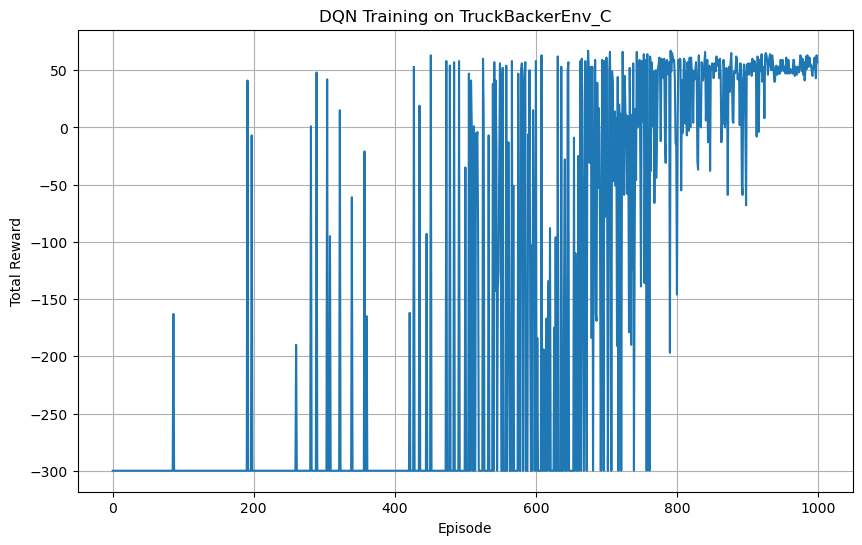

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training on TruckBackerEnv_C')
plt.grid(True)

# Save the plot to a file
plt.savefig('DQN_Discrete_TruckBackerEnv_D.png', dpi=300, bbox_inches='tight')

plt.show()

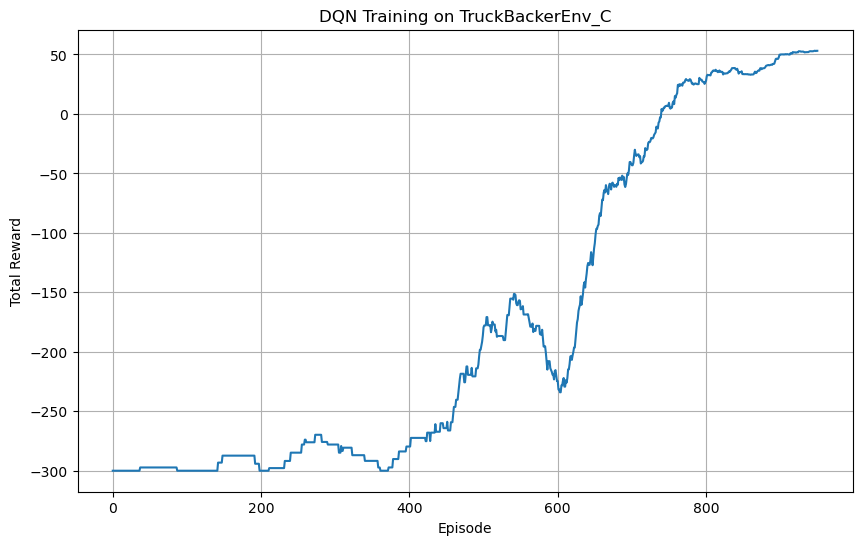

In [13]:
window = 50
smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')

# Plotting Results
plt.figure(figsize=(10, 6))
# plt.plot(episode_rewards)
plt.plot(smoothed)


plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training on TruckBackerEnv_C')
plt.grid(True)

# Save the plot to a file
plt.savefig('DQN_Discrete_TruckBackerEnv_D.png', dpi=300, bbox_inches='tight')

plt.show()